In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import pdb
import time

Hyper-parameters

In [2]:
batchsize = 32
lr = 0.001
epochs = 10

# Check GPU aviability
This project is executed with CPU

In [3]:
if torch.cuda.is_available():
    print(f'Found {torch.cuda.device_count()} GPUs avaliable.')
    CPU_mode = False
print('Working with CPU')

Found 4 GPUs avaliable.
Working with CPU


# DATA PREPARATION 
The Extract-Transform-Load principle of data preparation
CIFAR10 is built-in within torchvision.datasets, so that no need to separately call the torchvision.datasets.ImageFolder function to handle a non-built-in raw dataset. Yet torch.utils.data.DataLoader is still needed to take a proccessed dataset and generating batches to loop over it. 
torch.datasets.CIFAR10 will download the dataset onto the local directory for the first time.

In [4]:
# transform is a torchvision.transforms object
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

# download the CIFAR10 by torchvision, trainset is a torchvision.datasets object
# transform is performed while obtaining the dataset
# the ./data directory is automatically created, and once dowloaded, this code can sense it and will not
# download it agin
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
# load the datasets object with a torch.utils.data.DataLoader function, which returns a loaded dataset object 
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batchsize, shuffle = True, num_workers = 2)

testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)

testloader = torch.utils.data.DataLoader(testset, batch_size = batchsize, shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# Image displaying

In [5]:
import matplotlib.pyplot as plt 
import numpy as np 


def imshow(img):
    # normalizing
    img = img / 2 + 0.5 # imgs are already noramlized during Transforming in data prepration
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))), plt.show()


# get some random training imgs
# A dataloader is a generator to continue going over the entire set batch-by-batch
# To pick just one batch, call iter(dataloader) to return just one batch

dataiter = iter(trainloader)  # calling the iter() function on a torch.utils.data.DataLoader object
images, labels = dataiter.next() # the returned object from iter() has a method .next() to return a sample

imshow(torchvision.utils.make_grid(images))

# print label
print(' '.join('%5s' % classes[labels[j]] for j in range(batchsize)))

<Figure size 640x480 with 1 Axes>

 ship   car plane  deer   cat plane  bird  ship truck   car truck horse  frog  ship  ship  bird  bird horse plane  bird   car   dog plane  frog horse  frog  deer  bird   cat   car   dog truck


# Define the CNN network architecture by creating a new class #

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

net = Net()	

# Define Loss & Optimizer

In [7]:
import torch.optim as optim

# loss func "criterion" is a torch.nn.CrossEntropyLoss object
criterion = nn.CrossEntropyLoss()
# optimizer is a torch.optim.SGD object
optimizer = optim.SGD(net.parameters(), lr = lr, momentum = 0.9)

# Training

In [8]:
for epoch in range(epochs): # %%%%%%%%%%%%%% Outer loop to go over epochs
    since = time.time()
    running_loss = 0.0  # for computing a avg loss over itrs
    for i, data in enumerate(trainloader, 0): # %%%%%%%%%%%% inner loop over samples generated by dataloader
        # get the inputs
        inputs, labels = data

        # zero the params gradients for every new samples coming in
        optimizer.zero_grad()

        # Forward
        outputs = net(inputs)

        # Loss computation
        loss = criterion(outputs, labels)

        # BP, i.e. computes the gradients along the way, all tensor with .requries_grad() = True 
        # will store its gradient in the .grad attribute
        loss.backward()

        # Optimize
        optimizer.step()

        # print statistics
        running_loss += loss.item()  #tensor.item() convert scalar stored in a tensor to a number
        if i % 200 == 0:  # print every 100 itrs (batches)
            print(f'Epoch {epoch + 1} Itrs {i + 1}, Train_loss is: {running_loss / 2000}')
            running_loss = 0.0
    
    end = time.time()
    elapsed = end - since
    print(f'---------- Training of the {epoch + 1} epoch is over, takes {round(elapsed, 4)} sec.-------------')

Epoch 1 Itrs 1, Train_loss is: 0.0011480714082717895
Epoch 1 Itrs 201, Train_loss is: 0.230256995677948
Epoch 1 Itrs 401, Train_loss is: 0.22986097967624664
Epoch 1 Itrs 601, Train_loss is: 0.2291507487297058
Epoch 1 Itrs 801, Train_loss is: 0.22692825865745545
Epoch 1 Itrs 1001, Train_loss is: 0.21997549146413803
Epoch 1 Itrs 1201, Train_loss is: 0.21105360019207
Epoch 1 Itrs 1401, Train_loss is: 0.20477182239294053
---------- Training of the 1 epoch is over, takes 12.6965 sec.-------------
Epoch 2 Itrs 1, Train_loss is: 0.0009801201224327088
Epoch 2 Itrs 201, Train_loss is: 0.19574467074871063
Epoch 2 Itrs 401, Train_loss is: 0.19304117274284363
Epoch 2 Itrs 601, Train_loss is: 0.18848328346014023
Epoch 2 Itrs 801, Train_loss is: 0.1850529783964157
Epoch 2 Itrs 1001, Train_loss is: 0.17939018762111664
Epoch 2 Itrs 1201, Train_loss is: 0.17492870050668716
Epoch 2 Itrs 1401, Train_loss is: 0.16907026362419128
---------- Training of the 2 epoch is over, takes 12.6107 sec.-------------
E

# Testing

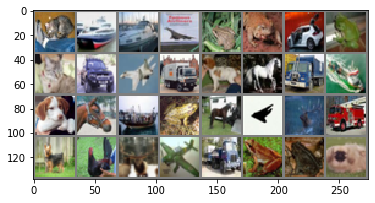

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# Display a batch of images from the test set
imshow(torchvision.utils.make_grid(images))

In [10]:
print(' '.join('%5s' % classes[labels[j]] for j in range(batchsize)))
outputs = net(images)

# pick out the hihgest prob out of the 10 classes as the predicetd class
_, predicted = torch.max(outputs, dim = 1)

print('Predicted ' + ' '.join('%5s' % classes[labels[j]] for j in range(batchsize)))
start_time = time.time()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
finish_time = time.time()
elapsed_time = finish_time - start_time

print(f'Acc on 10K test image is: {100 * correct / total}, used time: {elapsed_time} seconds')

  cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog
Predicted   cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship   dog horse  ship  frog horse plane  deer truck   dog  bird  deer plane truck  frog  frog   dog
Acc on 10K test image is: 59.05, used time: 1.0745806694030762 seconds


# Calculating per-class accuracy

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, dim = 1)
        c = (predicted == labels).squeeze()
        
        if len(labels) >= batchsize: # in case the last batch left is smaller than batchsize
            for i in range(batchsize):

                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
        else:
            pass

for i in range(10):
    print(f'ACC of {classes[i]}: {100 * class_correct[i] / class_total[i]}')

ACC of plane: 65.33066132264528
ACC of car: 73.47347347347348
ACC of bird: 37.13713713713714
ACC of cat: 37.512537612838514
ACC of deer: 48.7
ACC of dog: 51.4543630892678
ACC of frog: 78.1
ACC of horse: 71.01303911735205
ACC of ship: 75.52657973921765
ACC of truck: 52.5
